In [1]:
import os, sys
import numpy as np
import matplotlib
from matplotlib import animation
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch import nn as nn
from torch.optim import AdamW

import gym

from utils import seed_everything, plot_stats, display_video

# Utility

In [2]:
def test_policy_network(env, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render(mode="rgb_array"))

        while not done:
            state = torch.from_numpy(state).unsqueeze(0).float()
            action = policy(state).multinomial(1).item()
            next_state, _, done, _ = env.step(action)
            img = env.render(mode="rgb_array")
            frames.append(img)
            state = next_state

    return display_video(frames)


def plot_action_probs(probs, labels):
    plt.figure(figsize=(6, 4))
    plt.bar(labels, probs, color ='orange')
    plt.title("$\pi(s)$", size=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
/var/folders/w_/907_7v250273p09qmhk2l72m0000gn/T/ipykernel_4411/377624470.py:22: SyntaxWarning: invalid escape sequence '\p'
  plt.title("$\pi(s)$", size=16)


# Initialize the environment

In [4]:
env = gym.make("Acrobot-v1")

In [5]:
dims = env.observation_space.shape[0]
actions = env.action_space.n
print(f"State dimentions: {dims}, Actions: {actions}")
print(f"Sample state: {env.reset()}")

State dimentions: 6, Actions: 3
Sample state: [ 0.99635464  0.08530801  0.99778104 -0.06658039 -0.08686777  0.00457428]


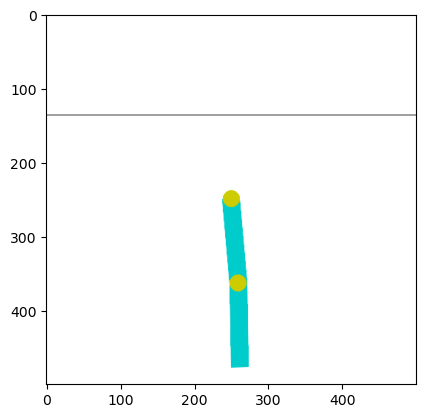

In [6]:
plt.imshow(env.render(mode="rgb_array"))

# Prepare the environment to work with PyTorch

In [7]:
class PreprocessEnv(gym.Wrapper):

    def __init__(self, env):
        gym.Wrapper.__init__(self, env)

    def reset(self):
        state = self.env.reset()
        return torch.from_numpy(state).float()

    def step(self, actions):
        actions = actions.squeeze().numpy()
        next_state, reward, done, info = self.env.step(actions)
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1)
        return next_state, reward, done, info

In [8]:
num_envs = os.cpu_count()
parallel_env = gym.vector.make('Acrobot-v1', num_envs=num_envs)
seed_everything(parallel_env)
parallel_env = PreprocessEnv(parallel_env)

In [9]:
parallel_env.reset()

tensor([[ 0.9985,  0.0548,  0.9999, -0.0122,  0.0717,  0.0395],
        [ 0.9995,  0.0305,  0.9958, -0.0911, -0.0960,  0.0678],
        [ 0.9972, -0.0754,  0.9988, -0.0484, -0.0188,  0.0938],
        [ 0.9999,  0.0146,  1.0000,  0.0057,  0.0527,  0.0623],
        [ 0.9967,  0.0810,  0.9964, -0.0845, -0.0455,  0.0244],
        [ 0.9988,  0.0483,  0.9987,  0.0507, -0.0070, -0.0793],
        [ 0.9997, -0.0225,  0.9998,  0.0192,  0.0028,  0.0389],
        [ 0.9996, -0.0274,  0.9998,  0.0186, -0.0216,  0.0247],
        [ 0.9983,  0.0575,  0.9978,  0.0667,  0.0096,  0.0947],
        [ 0.9961,  0.0884,  0.9993, -0.0386, -0.0490, -0.0555]])

# Create the policy  𝜋(𝑠)

In [10]:
actor = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, actions),
    nn.Softmax(dim=-1))

# Create the value network

In [11]:
critic = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1))

# Implement the algorithm

In [12]:
def actor_critic(actor, critic, episodes, alpha=1e-4, gamma=0.99):
    actor_optim = AdamW(actor.parameters(), lr=1e-3)
    critic_optim = AdamW(critic.parameters(), lr=1e-4)
    stats = {'Actor Loss': [], 'Critic Loss': [], 'Returns': []}

    for episode in tqdm(range(1, episodes + 1)):
        state = parallel_env.reset()
        done_b = torch.zeros((num_envs, 1), dtype=torch.bool)
        ep_return = torch.zeros((num_envs, 1))
        I = 1.

        while not done_b.all():
            action = actor(state).multinomial(1).detach()
            next_state, reward, done, _ = parallel_env.step(action)

            value = critic(state)
            target = reward + ~done * gamma * critic(next_state).detach()
            critic_loss = F.mse_loss(value, target)
            critic.zero_grad()
            critic_loss.backward()
            critic_optim.step()

            advantage = (target - value).detach()
            probs = actor(state)
            log_probs = torch.log(probs + 1e-6)
            action_log_prob = log_probs.gather(1, action)
            entropy = - torch.sum(probs * log_probs, dim=-1, keepdim=True)
            actor_loss = - I * action_log_prob * advantage - 0.01 * entropy
            actor_loss = actor_loss.mean()
            actor.zero_grad()
            actor_loss.backward()
            actor_optim.step()

            ep_return += reward
            done_b |= done
            state = next_state
            I = I * gamma

        stats['Actor Loss'].append(actor_loss.item())
        stats['Critic Loss'].append(critic_loss.item())
        stats['Returns'].append(ep_return.mean().item())

    return stats

In [13]:
stats = actor_critic(actor, critic, 100)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s]


# Show results

### Show execution stats

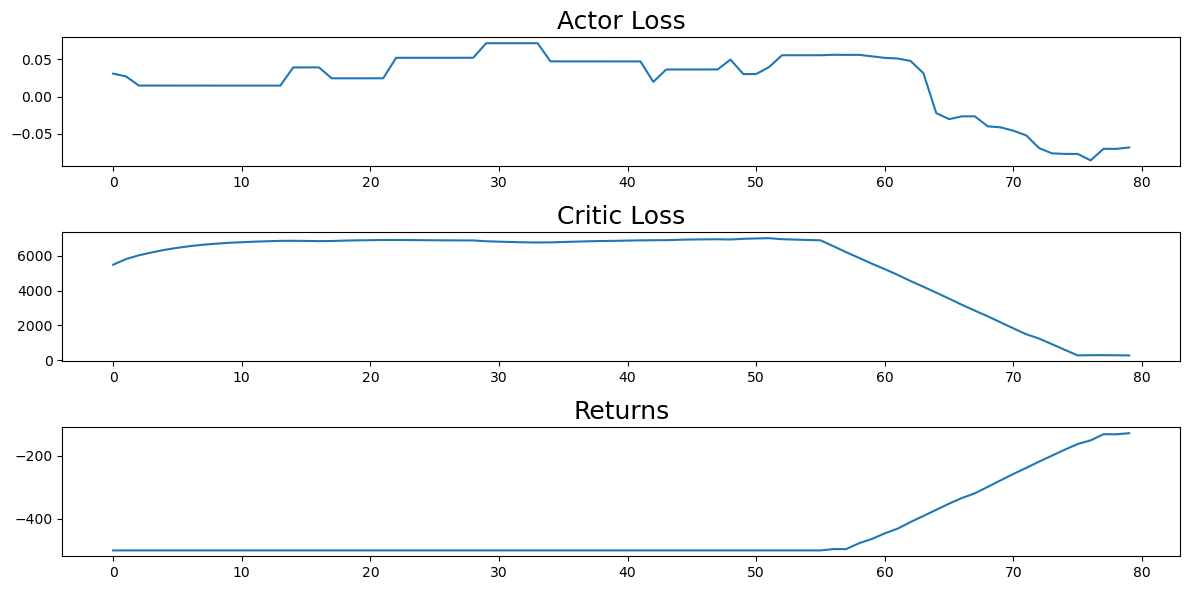

In [14]:
plot_stats(stats)

### Test the resulting agent

In [15]:
test_policy_network(env, actor, episodes=2)